

# MNIST Digit Classification



In [ ]:
# Import PyTorch and other relevant libraries
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torchsummary import summary

# other packages
import matplotlib.pyplot as plt
import numpy as np
import random
from tqdm import tqdm

In [ ]:

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

## 1.1 MNIST dataset


In [ ]:
torch.random.manual_seed(41)

In [ ]:
from torch.utils.data.dataset import random_split
transform = transforms.Compose([
    transforms.ToTensor()
])

full_train_dataset = datasets.MNIST(
    root = "./data",
    train = True,
    download = True,
    transform= transform
)

test_dataset = datasets.MNIST(
    root = "./data",
    train = False,
    download = True,
    transform= transform
)

# Split into train and validation

train_size = 50000
valid_size = len(full_train_dataset) - train_size

train_dataset, validation_dataset = random_split(
    full_train_dataset,
    [train_size, valid_size],
    generator=torch.Generator().manual_seed(42)
)

# Create Dataloader

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
valid_loader = DataLoader(validation_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=True)


100%|██████████| 9.91M/9.91M [00:00<00:00, 20.1MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 489kB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 4.42MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 3.82MB/s]


In [ ]:
image, label = next(iter(train_loader))
label

tensor([6, 1, 6, 2, 3, 7, 4, 7, 7, 1, 6, 6, 9, 6, 6, 0, 2, 1, 8, 9, 6, 7, 9, 7,
        0, 8, 5, 9, 1, 1, 2, 9, 0, 1, 1, 0, 7, 3, 4, 6, 3, 9, 7, 6, 1, 6, 9, 5,
        5, 5, 8, 2, 2, 1, 0, 6, 6, 2, 3, 1, 9, 7, 3, 7])

In [ ]:
image, label = train_dataset[0]
print(image.size())
print(label)

torch.Size([1, 28, 28])
6


Our training set is made up of 28x28 grayscale images of handwritten digits.

Let's visualize what some of these images and their corresponding training labels look like.

In [ ]:
plt.figure(figsize=(10,10))
random_inds = np.random.choice(50000,36)
for i in range(36):
    plt.subplot(6, 6, i + 1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    image_ind = random_inds[i]
    image, label = train_dataset[image_ind]
    plt.imshow(image.squeeze(), cmap=plt.cm.binary)
    plt.xlabel(label)

## 1.2 Neural Network for Handwritten Digit Classification

I'll first build a simple neural network consisting of two fully connected layers and apply this to the digit classification task. Our network will ultimately output a probability distribution over the 10 digit classes (0-9).



In [ ]:
nn.Flatten()(image).shape

torch.Size([1, 784])

In [ ]:
import torch.nn.functional as F
class MINST(nn.Module):
  def __init__(self, num_layers =5, input_size= 1*28*28, hidden_size=50, output_size=10) -> None:
      super().__init__()

      # First Flatten the 3d image to 2d
      self.flatten = nn.Flatten()

      # bulid the network layers
      self.layers = nn.ModuleList()
      self.layers.append(nn.Linear(input_size, hidden_size))
      for _ in range(num_layers):
        self.layers.append(nn.Linear(hidden_size, hidden_size))
      self.output = nn.Linear(hidden_size, output_size)


  def forward(self, X):
    x = self.flatten(X)
    for layer in self.layers:
      x = F.relu(layer(x))
      x = self.output(x)
      return x




In [ ]:
fc_model = MINST().to(device)
print(fc_model)

MINST(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (layers): ModuleList(
    (0): Linear(in_features=784, out_features=50, bias=True)
    (1-5): 5 x Linear(in_features=50, out_features=50, bias=True)
  )
  (output): Linear(in_features=50, out_features=10, bias=True)
)


In [ ]:
# Define loss function and optimizer
loss_function = nn.CrossEntropyLoss()
optimizer = optim.SGD(fc_model.parameters(), lr=0.1)

### Train the model


In [ ]:
from prompt_toolkit import history
from torchvision.io.video import av

class Trainer:
  def __init__(self, model, optimizer, loss_function, device=None):
    self.loss_function = loss_function
    self.optimizer = optimizer
    self.device = device if device else torch.device("cuda" if torch.cuda.is_available() else "cpu")
    self.model = model
    self.model.to(self.device)
    print(f"Trainer Object Initialized on Device: {self.device}")

  def _train_epoch(self, train_loader, verbose=False):
    """Internal Training method for a epoch

      return traing loss, training accuracy for one epoch
    """
    self.model.train() # Set the model in training mode

    correct, total = 0, 0
    training_loss = []

    loop = tqdm(train_loader, desc="Training", leave = False) if verbose else train_loader
    # Training loop
    for x_batch, y_batch in loop:
      x_batch, y_batch = x_batch.to(self.device), y_batch.to(self.device)

      # Forward pass
      outputs = self.model(x_batch)
      self.model.zero_grad()

      # Calculate loss and accuracy
      loss = self.loss_function(outputs, y_batch)
      loss.backward()
      self.optimizer.step()
      training_loss.append(loss.item())

      total += len(x_batch)
      predicted = torch.argmax(outputs, dim=1)
      correct += (predicted == y_batch).sum().item()

      if verbose:
        loop.set_postfix(loss=loss.item(), accuracy=100* correct/total)

    avg_train_loss = np.mean(training_loss)
    train_accuracy = correct / total * 100
    return avg_train_loss, train_accuracy

  def _validate_epoch(self, valid_loader, verbose=False):
      """ Internal Validation method for a epoch

      return validation loss, validation accuracy for one epoch
      """

      self.model.eval() # Set the model in evaluation mode

      correct, total = 0, 0
      validation_loss = []
      loop = tqdm(valid_loader, desc="Validation", leave = False) if verbose else valid_loader

      for x_val, y_val in loop:
        x_val, y_val = x_val.to(self.device), y_val.to(self.device)
        with torch.no_grad():
          outputs = self.model(x_val)
          loss = self.loss_function(outputs, y_val)
          validation_loss.append(loss.item())

          total += len(x_val)
          predicted = torch.argmax(outputs, dim=1)
          correct += (predicted == y_val).sum().item()
          if verbose:
            loop.set_postfix(loss=loss.item(), accuracy=100* correct/total)

      avg_val_loss = np.mean(validation_loss)
      val_accuracy = correct / total * 100
      return avg_val_loss, val_accuracy

  def fit(self, train_loader, validation_loader, epochs=10, verbose=True):
      """Trains and evaluates the model for a specified number of epochs."""
      history = {
              "train_accuracy": [],
              "train_loss": [],
              "val_accuracy": [],
              "val_loss": []
          }

      for epoch in range(epochs):
        # Training and validation for one epoch
        train_loss, train_acc = self._train_epoch(train_loader, verbose=verbose)
        val_loss, val_acc = self._validate_epoch(validation_loader, verbose=verbose)

        # Store history
        history['train_loss'].append(train_loss)
        history['train_accuracy'].append(train_acc)
        history['val_loss'].append(val_loss)
        history['val_accuracy'].append(val_acc)

        print(
            f"Epoch {epoch+1}/{epochs} | "
            f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}% | "
            f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%"
            )
      return history

  def test(self, test_loader, verbose=True):
        """
        Evaluates the model on the test set after training.
        """
        print("\nEvaluating on the test set...")
        avg_test_loss, test_accuracy = self._validate_epoch(test_loader, verbose=verbose)
        print(f"--> Test Loss: {avg_test_loss:.4f}, Test Accuracy: {test_accuracy:.2f}%")
        return avg_test_loss, test_accuracy


In [ ]:
model = MINST()
optimizer = torch.optim.NAdam(model.parameters(), lr=1e-3)
criterion = nn.CrossEntropyLoss()
trainer = Trainer(model,optimizer,criterion)

history = trainer.fit(
    epochs=10,
    train_loader=train_loader,
    validation_loader=valid_loader
)

Trainer Object Initialized on Device: cuda


Epoch 1/10 | Train Loss: 0.4418, Train Acc: 88.67% | Val Loss: 0.2694, Val Acc: 92.29%


Epoch 2/10 | Train Loss: 0.2262, Train Acc: 93.59% | Val Loss: 0.2118, Val Acc: 93.90%


Epoch 3/10 | Train Loss: 0.1736, Train Acc: 95.07% | Val Loss: 0.1768, Val Acc: 94.88%


Epoch 4/10 | Train Loss: 0.1408, Train Acc: 95.99% | Val Loss: 0.1562, Val Acc: 95.35%


Epoch 5/10 | Train Loss: 0.1194, Train Acc: 96.50% | Val Loss: 0.1411, Val Acc: 95.91%


Epoch 6/10 | Train Loss: 0.1031, Train Acc: 97.01% | Val Loss: 0.1368, Val Acc: 96.09%


Epoch 7/10 | Train Loss: 0.0901, Train Acc: 97.33% | Val Loss: 0.1283, Val Acc: 96.45%


Epoch 8/10 | Train Loss: 0.0801, Train Acc: 97.65% | Val Loss: 0.1245, Val Acc: 96.35%


Epoch 9/10 | Train Loss: 0.0711, Train Acc: 97.90% | Val Loss: 0.1247, Val Acc: 96.32%


Epoch 10/10 | Train Loss: 0.0637, Train Acc: 98.18% | Val Loss: 0.1167, Val Acc: 96.70%


In [ ]:
test_loss, test_accuracy = trainer.test(test_loader)


Evaluating on the test set...


--> Test Loss: 0.1011, Test Accuracy: 96.99%


In [ ]:
print(f'Test Accuracy: {test_accuracy}')

## 1.3 Convolutional Neural Network (CNN) for handwritten digit classification

Now build a CNN composed of two convolutional layers and pooling layers, followed by two fully connected layers, and ultimately output a probability distribution over the 10 digit classes (0-9).

In [ ]:
class MNST_CNN(nn.Module):
  def __init__(self, con_kernal=3, pooling_kernal=2, stride=1, padding=0, output_size = 10) -> None:
    super().__init__()

    self.conv1 = nn.Conv2d(in_channels=1, out_channels=24, kernel_size=con_kernal, stride=stride, padding=padding)
    self.conv2 = nn.Conv2d(in_channels=24, out_channels=36, kernel_size=con_kernal, stride=stride, padding=padding)
    self.pool = nn.MaxPool2d(kernel_size=pooling_kernal, stride=2)
    # Input: 28x28 -> conv1: 26x26 -> pool: 13x13
    # -> conv2: 11x11 -> pool-> 5x5
    # Number of features = 36 * 5 * 5 = 900
    self.flatten = nn.Flatten()
    self.fc1 = nn.Linear(36 * 5 * 5, 128) # or self.adaptive_pool = nn.AdaptiveAvgPool2d((1,1)) no need to know the out putsize form cnn
    self.output = nn.Linear(128,output_size)

  def forward(self, x):
    x = F.relu(self.conv1(x))
    x = self.pool(x)
    x =F.relu(self.conv2(x))
    x = self.pool(x)

    x = self.flatten(x)
    x = F.relu(self.fc1(x))
    x = self.output(x)
    return x


# This is for dummy initilaization for the first FC layer to know the input size
# Udefining manually (5*5*36) or using AdaptiveAvgPool dosnt need this step

# Instantiate the model
cnn_model = MNST_CNN().to(device)
# Initialize the model by passing some data through
image, label = train_dataset[0]
image = image.to(device).unsqueeze(0)  # Add batch dimension, Shape: (1, 1, 28, 28)
output = cnn_model(image)
# Print the model summary
print(cnn_model)


MNST_CNN(
  (conv1): Conv2d(1, 24, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(24, 36, kernel_size=(3, 3), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (fc1): Linear(in_features=900, out_features=128, bias=True)
  (output): Linear(in_features=128, out_features=10, bias=True)
)


### Train and test the CNN model

In [ ]:
model = MNST_CNN()
optimizer = torch.optim.NAdam(model.parameters(), lr=1e-3)
criterion = nn.CrossEntropyLoss()
trainer = Trainer(model,optimizer,criterion)

history = trainer.fit(
    epochs=10,
    train_loader=train_loader,
    validation_loader=valid_loader
)

Trainer Object Initialized on Device: cuda


Epoch 1/10 | Train Loss: 0.2286, Train Acc: 92.94% | Val Loss: 0.0830, Val Acc: 97.56%


Epoch 2/10 | Train Loss: 0.0638, Train Acc: 97.99% | Val Loss: 0.0604, Val Acc: 98.09%


Epoch 3/10 | Train Loss: 0.0447, Train Acc: 98.63% | Val Loss: 0.0549, Val Acc: 98.50%


Epoch 4/10 | Train Loss: 0.0324, Train Acc: 98.97% | Val Loss: 0.0447, Val Acc: 98.68%


Epoch 5/10 | Train Loss: 0.0260, Train Acc: 99.20% | Val Loss: 0.0416, Val Acc: 98.87%


Epoch 6/10 | Train Loss: 0.0204, Train Acc: 99.39% | Val Loss: 0.0484, Val Acc: 98.75%


Epoch 7/10 | Train Loss: 0.0172, Train Acc: 99.42% | Val Loss: 0.0403, Val Acc: 98.78%


Epoch 8/10 | Train Loss: 0.0128, Train Acc: 99.61% | Val Loss: 0.0446, Val Acc: 98.83%


Epoch 9/10 | Train Loss: 0.0116, Train Acc: 99.63% | Val Loss: 0.0402, Val Acc: 99.02%


Epoch 10/10 | Train Loss: 0.0091, Train Acc: 99.70% | Val Loss: 0.0393, Val Acc: 99.06%


### Evaluate the CNN Model

Now that we've trained the model, let's evaluate it on the test dataset.

In [ ]:
test_loss, test_acc = trainer.test(test_loader, verbose=True)

print('Test accuracy:', test_acc)


Evaluating on the test set...


--> Test Loss: 0.0337, Test Accuracy: 99.03%
Test accuracy: 99.03


### Make predictions with the CNN model


In [ ]:
test_image, test_label = test_dataset[0]
test_image = test_image.to(device).unsqueeze(0)

# put the model in evaluation (inference) mode
model.eval()
predictions_test_image = model(test_image)

In [ ]:
print(test_label)
print(predictions_test_image)

7
tensor([[ -9.2543,  -4.8646,  -4.5226,  -3.6086,  -2.1862,  -8.6761, -24.5398,
          17.1091,  -3.9432,   0.8951]], device='cuda:0',
       grad_fn=<AddmmBackward0>)


In [ ]:
x = torch.nn.functional.softmax(predictions_test_image, dim=1)
torch.max(x, dim=1)

torch.return_types.max(
values=tensor([1.0000], device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor([7], device='cuda:0'))

# Visualize the Predicted Output with Confdence Score

In [ ]:

# # Initialize new comet experiment
# comet_ml.init(project_name="6.s191lab2_part1_CNN")
# comet_model_2 = comet_ml.Experiment()
# Initialize variables to store all data
all_predictions = []
all_labels = []
all_images = []

# Process test set in batches
with torch.no_grad():
    for images, labels in test_loader:
        # Move images and labels to the same device as the model
        images = images.to(device)
        labels = labels.to(device)

        outputs = model(images)

        # Apply softmax to get probabilities from the predicted logits
        probabilities = torch.nn.functional.softmax(outputs, dim=1)

        # Get predicted classes
        predicted = torch.argmax(probabilities, dim=1)

        all_predictions.append(probabilities)
        all_labels.append(labels)
        all_images.append(images)

# Convert tensors back to CPU for concatenation and then to NumPy for plotting
all_predictions = torch.cat(all_predictions).cpu()  # Shape: (total_samples, num_classes)
all_labels = torch.cat(all_labels).cpu()            # Shape: (total_samples,)
all_images = torch.cat(all_images).cpu()            # Shape: (total_samples, 1, 28, 28)

# Convert tensors to NumPy for compatibility with plotting functions
predictions = all_predictions.numpy()  # Shape: (total_samples, num_classes)
test_labels = all_labels.numpy()       # Shape: (total_samples,)
test_images = all_images.numpy()       # Shape: (total_samples, 1, 28, 28)

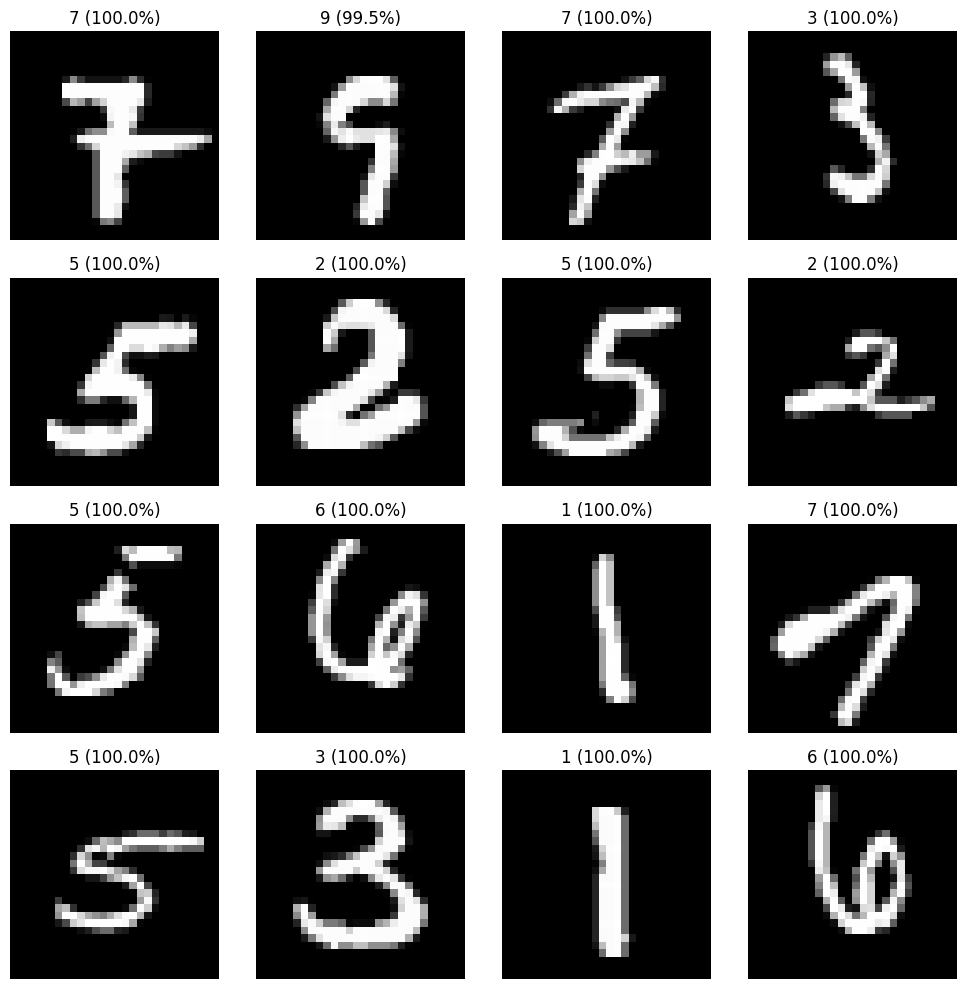

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Number of images to display
num_images = 16
fig, axes = plt.subplots(4, 4, figsize=(10, 10))
axes = axes.flatten()

for i in range(num_images):
    img = test_images[i].squeeze()
    pred_probs = predictions[i]
    pred_label = np.argmax(pred_probs)
    confidence = pred_probs[pred_label] * 100

    axes[i].imshow(img, cmap='gray')
    axes[i].axis('off')
    axes[i].set_title(f"{pred_label} ({confidence:.1f}%)")

plt.tight_layout()
plt.show()
